In [28]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import geo_dist as gd



In [29]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [30]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 20., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
#mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
mag_par = np.array([-1.,0., 0.])

#Set up observering condidtions before making any VDFs
#veloity grid
#########################################
######################################
#grid_v = np.arange(450,790,15
v_mag = np.sqrt(np.sum(pls_par**2))
grid_v = np.arange(v_mag-150,v_mag+150,15)
#get effective area of wind and other coversion parameters
waeff = 3.8e6 #cm^3/km
q0    = 1.6021892e-7 # picocoulombs
dv    = np.diff(grid_v)
dv    = np.concatenate([dv,[dv[-1]]])
cont  = 1.e12/(waeff*q0*dv*grid_v)

In [31]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
normval = np.ones(dis_vdf['pgrid'].shape)
normval /= np.sum(normval)

#Add a positive Gaussian Kernal to "Measured" VDF
dis_vdf['vdf'] += dis_vdf['vdf'].max()*np.exp(- ((dis_vdf['pgrid']-(-100))/10)**2. - ((dis_vdf['qgrid']-(0))/5)**2.)
#update the interpolator function
dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
                         

#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20
#set random seed for FC angles
#np.random.seed(1107)


#Get two uniform number between -30 and 30
limit = 90.
phis = np.random.uniform(-limit,limit,size=ncup)
thetas = np.random.uniform(-30.,30.,size=ncup)


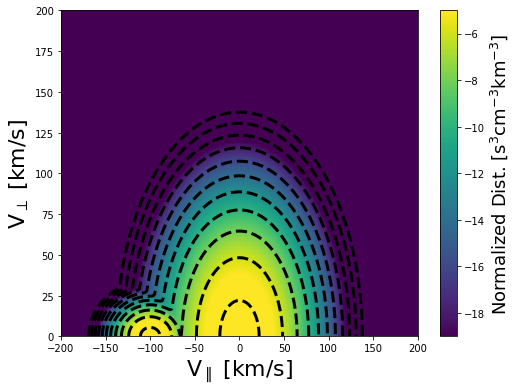

In [32]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [33]:

#array that store all the fit parameters 
big_arr = []
#calculate the "real measured reduced response function" for all fc cups
fcs = {}
for k,(phi,theta) in enumerate(zip(phis,thetas)):
    #calculate x_meas array
    x_meas = mdv.make_fc_meas(dis_vdf,fc_spd=grid_v,fc_phi=phi,fc_theta=theta)
    #compute the observed current in the instrument
    #Use dynamic sampling 2018/10/12 J. Prchlik
    #rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    rad_phi,rad_theta = np.radians((phi,theta))
    pro_unt = np.array([np.cos(rad_phi)*np.cos(rad_theta),np.sin(rad_phi)*np.cos(rad_theta),np.sin(rad_theta)])
    peak = np.abs(pls_par[:3].dot(pro_unt))
    #here sampling is in km/s
    rea_cur = mdv.arb_p_response(x_meas,dis_vdf,samp)
    #switched back to static sampling but now using p',q',r' for sampling
    #rea_cur = mdv.arb_p_response_dyn_samp(x_meas,dis_vdf,peak)

    #create key for input fc
    key = 'fc_{0:1d}'.format(k)
    fcs[key] = {}

    #populate key with measurements and parameter 
    fcs[key]['x_meas']  = x_meas
    fcs[key]['rea_cur'] = rea_cur
    fcs[key]['peak']    = peak


    #calculate the Gaussian fit of the response
    try:
        popt, pcov = curve_fit(gaus,grid_v,rea_cur*cont,p0=[np.nanmax(rea_cur*cont),np.mean(grid_v),np.sqrt(2.)*2*dv[0]],sigma=1./(rea_cur/rea_cur.min()),maxfev=5000)
    except RuntimeError:
        #give number that will be thrown out if no fit is found 
        popt = np.zeros(3)-9999.9
        pcov = np.zeros((3,3))-9999.9


    #Switched to computing the average
    #####get the parameters from the fit
    u = popt[1] #speed in km/s
    w = np.abs(popt[2]*np.sqrt(2.)) #thermal speed in km/s
    n = popt[0]*w*np.sqrt(np.pi) #density in cc
    ####
    #####uncertainty in parameters from fit
    du = np.sqrt(pcov[1,1])
    dw = np.sqrt(pcov[2,2])
    dn = np.sqrt(np.pi*((w**2.*pcov[0,0]) + (dw*n)**2))


    #Add fit parameters with velocity guesses
    big_arr.append([u,w,n,phi,theta,du,dw,dn])


#convert big_arr intop numpy array
big_arr = np.array(big_arr)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [34]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]



#Number of processors to use when parallel processing
nproc = 8




In [35]:
#Use the top 5 peaks to get density and velocity values if the number of measurements are greater than 5
top5 = n_angl > np.sort(n_angl)[-6]

#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


In [36]:
#Get Wper and Wpar vectors using SVD and the magnetic field vectors
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.abs(wv_par.dot(mag_par))
we = np.sqrt(np.linalg.norm(wv_par)**2.-wv_par.dot(mag_par)**2.)



In [37]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [38]:
#dont let initial guess be smaller than half a bin size
if we < min(dv)/2.:
    we = min(dv)/2.


#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [99]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [40]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [100]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   20.   15.]
[-579.98873164    9.97431007   -9.15361771    7.5          21.82347767
   13.18899743]


In [42]:
#Updated MC guess based on poor judgement of perpendicular velocity component
pgrid = np.abs(dis_vdf_bad_guess['pgrid'].ravel())
qgrid = np.abs(dis_vdf_bad_guess['qgrid'].ravel())

dis = np.zeros(pgrid.size)
for i,(x,y) in enumerate(zip(pgrid,qgrid)):
    dis[i] = gd.distance_point_ellipse(wa,we,x,y)
    
dist = dis.reshape(dis_vdf_bad_guess['pgrid'].shape)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


3.05660559409e-85


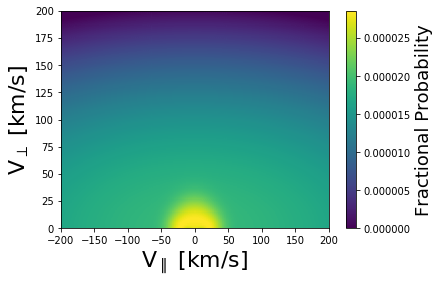

In [108]:
#Guess width
g_wid = 20 #km/s

#Initial guess around current guess of 2d VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#maximum value in VDF guess solution
max_pred_grid_norm = np.max(pred_grid)

#Initial guess based on ellipse near the kinematic values of the solar wind 
pred_grid += 0.5*max_pred_grid_norm*np.exp(- (dist/g_wid)**2.)


#Add a second component near 90 km/s
#pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((dis_vdf['pgrid']-(-90))/g_wid)**2.)

#Also add a band at a radius of 90 km/s
#pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((np.sqrt((dis_vdf['pgrid']**2+dis_vdf['qgrid']**2))-(90))/g_wid)**2.)

#get normalization factor
pred_grid /= np.sum(pred_grid)


print(np.min(pred_grid))
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()


In [116]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.



#counter tells the number of iterations to go before resetting the initial guess PDF
counter = 0
#Number of iterations before resetting
tol_cnt = 100
#kernel size for fitting
kernel = wa/np.sqrt(2.)

In [137]:
#Loop until completion
looper = True

start_loop = time.time()
#removed to test improving fit
for i in range(3000):
    #error from previous iteration
    pre_err = per_err
    #get a new vdf and return if it is the best fit
    #dis_vdf_bad,tot_error,dis_cur = create_random_vdf(dis_vdf_bad,nproc,n_p_prob)
    #print(ip,iq,n_p_prob)
    fcs,tot_err,dis_vdf_bad,improved,ip,iq,n_p_prob = mff.create_random_vdf_multi_fc(fcs,nproc,tot_err,
                                                                            dis_vdf_bad,cont,pred_grid,
                                                                            kernel,
                                                                            improved=improved,ip=ip,
                                                                            iq=iq,n_p_prob=n_p_prob,
                                                                            sc_range=0.1,samp=samp)
    
    if improved:
        #scale probability by how large of a jump is made
        if tot_err > 1e30:
            scale = 0.1
        else:
            scale = (pre_err-tot_err)
            if scale < 0.:
                scale = 0.
        
        #calculate peak at ip,iq value using the percent error change
        a = 100.*(scale)/float(pred_grid.size)
        
        #Also add a band at a radius p,q values
        r_ipq = np.sqrt(ip**2+iq**2)
        #Add probability kernel at that location
        pred_grid += a*np.exp(- ((np.sqrt((dis_vdf_bad['pgrid']**2+dis_vdf_bad['qgrid']**2))-(r_ipq))/g_wid)**2.)
        #normalize to 1
        pred_grid /= np.sum(pred_grid)
        
        #Remove 10 guesses for counter for bad guesses
        counter -= 10
        #Do not let counter go below 0
        if counter < 0:
            counter = 0
    else:
        #increment the bad guess for the current model pdf
        counter += 1
        #reset the grid back to the default if there are too many bad guess with current pdf
        #do not probe velocity structures less than the measured spacing in the FC
        if ((counter > tol_cnt) & (kernel >= 15)):
            #reset the grid
            pred_grid = default_grid
            counter = 0
            if kernel >= 15.:
               #decrease the kernel size by 10%
               kernel *= 0.9
        print('Current Kerel Size',round(kernel*np.sqrt(2.)))
        
         
    per_err = tot_err

    print('Total error for iteration {0:1d} is {1:4.3e}%'.format(i,100.*float(tot_err)))

end_loop = time.time()
print('Loop time {0:1.1f}s'.format(end_loop-start_loop))

('Current Kerel Size', 12.0)
Total error for iteration 0 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 3 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 4 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 5 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 6 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 7 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 8 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 9 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 10 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 11 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 12 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 13 is 7.489e+00%
('

('Current Kerel Size', 12.0)
Total error for iteration 114 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 115 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 116 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 117 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 118 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 119 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 120 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 121 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 122 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 123 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 124 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 125 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 126 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 227 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 228 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 229 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 230 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 231 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 232 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 233 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 234 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 235 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 236 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 237 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 238 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iteration 239 is 7.489e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 341 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 342 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 343 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 344 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 345 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 346 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 347 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 348 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 349 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 350 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 351 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 352 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 353 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 454 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 455 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 456 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 457 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 458 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 459 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 460 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 461 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 462 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 463 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 464 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 465 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iteration 466 is 7.486e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 567 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 568 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 569 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 570 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 571 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 572 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 573 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 574 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 575 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 576 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 577 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 578 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iteration 579 is 7.485e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 680 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 681 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 682 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 683 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 684 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 685 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 686 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 687 is 7.424e+00%
('Current Kerel Size', 12.0)
Total error for iteration 688 is 7.424e+00%
Total error for iteration 689 is 7.389e+00%
Total error for iteration 690 is 7.386e+00%
Total error for iteration 691 is 7.384e+00%
('Current Kerel Size', 12.0)
Total error for iteration 692 is 7.384e+00%
('Current Kerel Size', 12.0)
Total error for iteration 693 is 7.384e+00%
('Current Kerel Size', 12.0)
Total error for iteration 694 is 7.3

('Current Kerel Size', 12.0)
Total error for iteration 794 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 795 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 796 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 797 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 798 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 799 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 800 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 801 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 802 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 803 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 804 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 805 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iteration 806 is 7.380e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 908 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 909 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 910 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 911 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 912 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 913 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 914 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 915 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 916 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 917 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 918 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 919 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iteration 920 is 7.369e+00%
('Current Kerel Size', 12.0)
Total error for iterat

('Current Kerel Size', 12.0)
Total error for iteration 1021 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1022 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1023 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1024 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1025 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1026 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1027 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1028 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1029 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1030 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1031 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1032 is 7.362e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1033 is 7.362e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1133 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1134 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1135 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1136 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1137 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1138 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1139 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1140 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1141 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1142 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1143 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1144 is 7.352e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1145 is 7.352e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1246 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1247 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1248 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1249 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1250 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1251 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1252 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1253 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1254 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1255 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1256 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1257 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1258 is 7.334e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1357 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1358 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1359 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1360 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1361 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1362 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1363 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1364 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1365 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1366 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1367 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1368 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1369 is 7.334e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1468 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1469 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1470 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1471 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1472 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1473 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1474 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1475 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1476 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1477 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1478 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1479 is 7.334e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1480 is 7.334e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1580 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1581 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1582 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1583 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1584 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1585 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1586 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1587 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1588 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1589 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1590 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1591 is 7.329e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1592 is 7.329e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1691 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1692 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1693 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1694 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1695 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1696 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1697 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1698 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1699 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1700 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1701 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1702 is 7.328e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1703 is 7.328e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1802 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1803 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1804 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1805 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1806 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1807 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1808 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1809 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1810 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1811 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1812 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1813 is 7.327e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1814 is 7.327e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 1913 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1914 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1915 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1916 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1917 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1918 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1919 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1920 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1921 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1922 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1923 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1924 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 1925 is 7.326e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2024 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2025 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2026 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2027 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2028 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2029 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2030 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2031 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2032 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2033 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2034 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2035 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2036 is 7.326e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2135 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2136 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2137 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2138 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2139 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2140 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2141 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2142 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2143 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2144 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2145 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2146 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2147 is 7.326e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2246 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2247 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2248 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2249 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2250 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2251 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2252 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2253 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2254 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2255 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2256 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2257 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2258 is 7.326e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2357 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2358 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2359 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2360 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2361 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2362 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2363 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2364 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2365 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2366 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2367 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2368 is 7.326e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2369 is 7.326e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2468 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2469 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2470 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2471 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2472 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2473 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2474 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2475 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2476 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2477 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2478 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2479 is 7.325e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2480 is 7.325e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2580 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2581 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2582 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2583 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2584 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2585 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2586 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2587 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2588 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2589 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2590 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2591 is 7.319e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2592 is 7.319e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2694 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2695 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2696 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2697 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2698 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2699 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2700 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2701 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2702 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2703 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2704 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2705 is 7.304e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2706 is 7.304e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2805 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2806 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2807 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2808 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2809 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2810 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2811 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2812 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2813 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2814 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2815 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2816 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2817 is 7.303e+00%
('Current Kerel Size', 12.0)
Total err

('Current Kerel Size', 12.0)
Total error for iteration 2916 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2917 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2918 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2919 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2920 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2921 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2922 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2923 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2924 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2925 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2926 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2927 is 7.303e+00%
('Current Kerel Size', 12.0)
Total error for iteration 2928 is 7.303e+00%
('Current Kerel Size', 12.0)
Total err

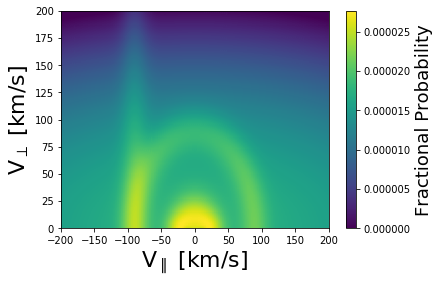

In [138]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


1.50381359796e-46


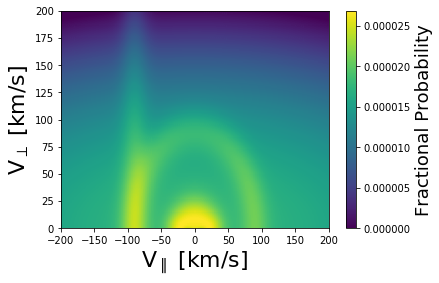

In [139]:
#Guess width
g_wid = 20 #km/s

#Initial guess around current guess of 2d VDF
pred_grid = np.log10(dis_vdf_bad_guess['vdf'])
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#maximum value in VDF guess solution
max_pred_grid_norm = np.max(pred_grid)

#Initial guess based on ellipse near the kinematic values of the solar wind 
pred_grid += 0.5*max_pred_grid_norm*np.exp(- (dist/g_wid)**2.)


#Add a second component near 90 km/s
pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((dis_vdf['pgrid']-(-90))/g_wid)**2.)

#Also add a band at a radius of 90 km/s
pred_grid += 0.2*max_pred_grid_norm*np.exp(- ((np.sqrt((dis_vdf['pgrid']**2+dis_vdf['qgrid']**2))-(90))/g_wid)**2.)

#get normalization factor
pred_grid /= np.sum(pred_grid)


print(np.min(pred_grid))
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

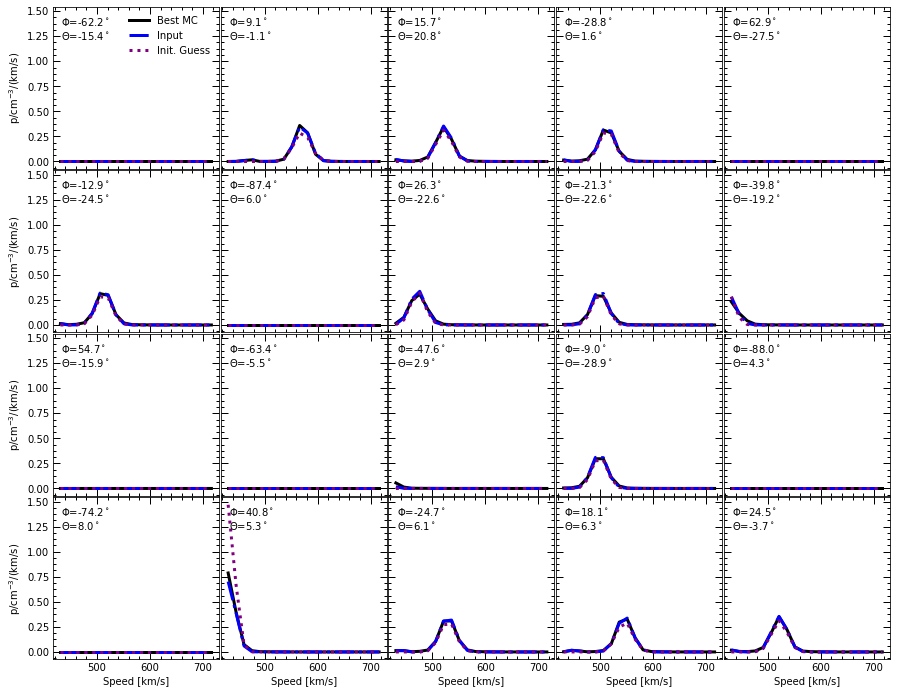

In [142]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

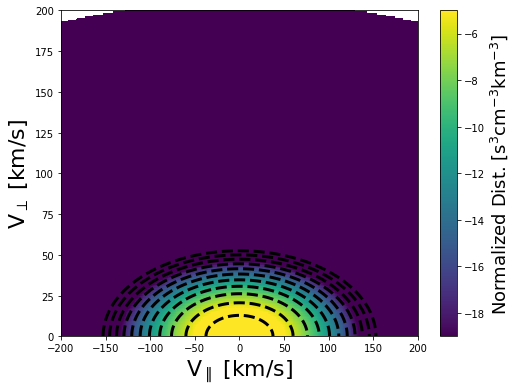

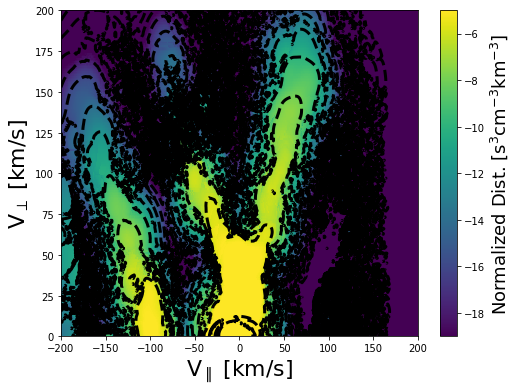

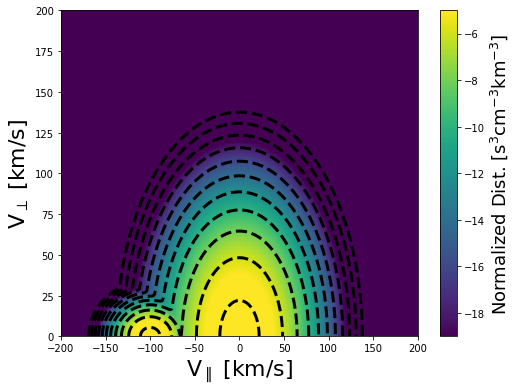

In [143]:
#Initial Guess from measurements
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

plt.show()